# Purpose

Attempt to perform an Decision Tree classifier on the cves/metasploit dataset

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, fbeta_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.metrics import fbeta_score, make_scorer

from IPython.display import Image  

import pydotplus


%matplotlib inline


In [5]:
CVES_METASPLOIT_ENCODED = '../../data/processed/cves_metasplot_encoded.json'

In [6]:
cves_df = pd.read_json(CVES_METASPLOIT_ENCODED)
cves_df.head()

,id,metasploit,access_ADJACENT,access_LOCAL,access_NETWORK,auth_HIGH,auth_LOW,auth_NONE,avail_HIGH,avail_LOW,avail_NONE,comp_HIGH,comp_LOW,conf_HIGH,conf_LOW,conf_NONE,integ_HIGH,integ_LOW,integ_NONE
0,CVE-1999-0001,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1
1,CVE-1999-0002,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0
2,CVE-1999-0003,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0
3,CVE-1999-0004,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1
4,CVE-1999-0005,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,1,0,0


In [7]:
X = cves_df.drop(['metasploit', 'id'], axis=1)
y = cves_df['metasploit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [8]:
y_train.mean()

0.014387816583906423

In [9]:
y_test.mean()

0.013961605584642234

Fighting an imbalance problem here, going to keep above for notes and keep experimenting below

In [10]:
param_grid = {"criterion" : ["gini", "entropy"],
              "splitter" :   ["best", "random"],
              "max_depth": [5,6,7,8,9,10, 20, 40, 80, 100],
              "min_samples_split": [2, 4, 8, 16, 24, 48],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6],
              "max_features": [1, 2, 3, 4, 5, 6, 7],
              
             }

model = DecisionTreeClassifier(
    random_state = 11, 
    max_features = "auto", 
    class_weight = "balanced"
)

# run grid search
f10_scorer = make_scorer(fbeta_score, beta=10)

grid_search_model = GridSearchCV(model, param_grid=param_grid, scoring=f10_scorer, cv=5, n_jobs=-1)

grid_search_model.fit(X_train, y_train)
print(grid_search_model)
print(grid_search_model.best_score_)
print(grid_search_model.best_params_)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=11,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'cr

In [11]:
model = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=7, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=16,
            min_weight_fraction_leaf=0.0, random_state=11,
            splitter='best')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

display(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
print("Training Accuracy:", model.score(X_train, y_train))
print("Test Accuracy    :", model.score(X_test, y_test))
print("F10 Score        :", fbeta_score(y_test, y_pred, 10))
print()
print(classification_report(y_test, y_pred))

Predicted,0,1,All
True,,,
0,19360,12280,31640
1,125,323,448
All,19485,12603,32088


Training Accuracy: 0.6117678834846565
Test Accuracy    : 0.6134068810770381
F10 Score        : 0.5683152448478304

              precision    recall  f1-score   support

           0       0.99      0.61      0.76     31640
           1       0.03      0.72      0.05       448

    accuracy                           0.61     32088
   macro avg       0.51      0.67      0.40     32088
weighted avg       0.98      0.61      0.75     32088



In [12]:
# Perform cross fold validation
model = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=7, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=16,
            min_weight_fraction_leaf=0.0, random_state=11,
            splitter='best')
model.fit(X_train, y_train)
scores = cross_val_score(model, X, y, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.54055317 0.51928321 0.46910791 0.5453058  0.62290612 0.66303078
 0.62049085 0.67253603 0.68476821 0.67658746]
Accuracy: 0.60 (+/- 0.15)


In [13]:
X_train.columns

Index(['access_ADJACENT', 'access_LOCAL', 'access_NETWORK', 'auth_HIGH',
       'auth_LOW', 'auth_NONE', 'avail_HIGH', 'avail_LOW', 'avail_NONE',
       'comp_HIGH', 'comp_LOW', 'conf_HIGH', 'conf_LOW', 'conf_NONE',
       'integ_HIGH', 'integ_LOW', 'integ_NONE'],
      dtype='object')

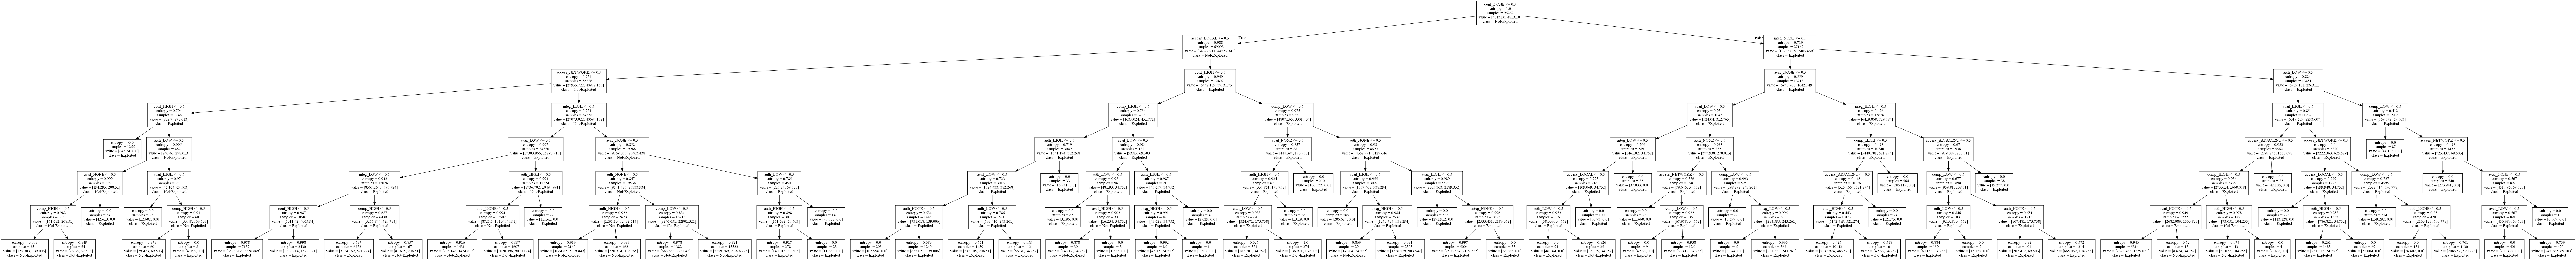

In [14]:
dot_data = export_graphviz(model, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=['Exploited', 'Not-Exploited'])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())